In [2]:
import sys
sys.path.append('..')

from functools import reduce, partial
import inspect

from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

import warnings
warnings.filterwarnings("ignore")

from Utilities import *

Pixiedust database opened successfully


In [3]:
path1 = '../datasets/10hz.csv'
dataset = pd.read_csv(path1)[499:].reset_index()
length, width = dataset.shape

In [87]:
dataset.head(10)

index    t         f     s  aIndex  aName          x         y         z  \
0    499  500  9.923777  50.0       6  yawCW -15.003883  5.732390 -5.845928   
1    500  501  9.874666  50.0       6  yawCW -15.060208  6.028467 -5.880797   
2    501  502  9.826017  50.0       6  yawCW -15.116282  6.323367 -5.907908   
3    502  503  9.874666  50.0       6  yawCW -15.172176  6.617707 -5.928142   
4    503  504  9.874643  50.0       6  yawCW -15.226247  6.902925 -5.943594   
5    504  505  9.874643  50.0       6  yawCW -15.281771  7.196342 -5.956308   
6    505  506  9.874620  50.0       6  yawCW -15.337127  7.489339 -5.966441   
7    506  507  9.874666  50.0       6  yawCW -15.392350  7.781937 -5.974497   
8    507  508  9.874690  50.0       6  yawCW -15.445861  8.065552 -5.980704   
9    508  509  9.874643  50.0       6  yawCW -15.500951  8.357363 -5.985757   

        dXB    ...       scalar         i         j         k      dPsi  \
0 -2.678520    ...    -0.610771  0.015250 -0.014274 -0.791532 -0.077678   
1 -2.605913    ...    -0.594480  0.001107 -0.001182 -0.804108 -0.013026   
2 -2.500035    ...    -0.566499 -0.000049 -0.000007 -0.824062 -0.001775   
3 -2.356970    ...    -0.531210 -0.000131  0.000097 -0.847240 -0.000399   
4 -2.169208    ...    -0.488514 -0.000125  0.000099 -0.872556 -0.000155   
5 -1.942721    ...    -0.440860 -0.000119  0.000102 -0.897576 -0.000284   
6 -1.681236    ...    -0.389348 -0.000104  0.000104 -0.921091 -0.000410   
7 -1.389243    ...    -0.334820 -0.000083  0.000104 -0.942282 -0.000674   
8 -1.081560    ...    -0.279641 -0.000062  0.000110 -0.960105 -0.000687   
9 -0.745097    ...    -0.220995 -0.000044  0.000125 -0.975275 -0.000908   

     dTheta      dPhi     d2Psi    d2Theta     d2Phi  
0 -1.589278  0.233684  1.122162  64.267105  3.246720  
1 -0.043041  0.556603  0.531784   1.885033  2.617555  
2 -0.018210  0.776516  0.059578   0.668583  1.752138  
3 -0.002255  0.923719  0.005158   0.096867  1.172821  
4 -0.002471  1.019883 -0.013383   0.081298  0.794368  
5 -0.002192  1.086621 -0.011342   0.081736  0.531723  
6 -0.001820  1.131293 -0.011857   0.079624  0.355916  
7 -0.001279  1.161195 -0.039954   0.042863  0.238237  
8 -0.001169  1.180728 -0.007511   0.065466  0.161363  
9 -0.000861  1.194285 -0.002214   0.054311  0.108010  

[10 rows x 34 columns]

In [51]:
def getInputOutputAccelerationModel(df, frequency, limit=500):
    v, w, a, alpha = getAveragesBody(df, limit, frequency=frequency)
    X, y = np.zeros((limit, 13)), np.zeros((limit, 6))

    inverseKeymap = {'moveForward': 0, 'yawCCW': 0, 'yawCW': 0, 'hover': 0}

    for i in range(limit - 2):
        rowi, action = df.iloc[i + 1], df.loc[i + 2, 'aName']
        X[i] = np.concatenate((v[i], w[i], getGravityVector(rowi['psi'], rowi['theta']),
                               [0 if k != action else 1 for k, v in inverseKeymap.items()]))
        y[i] = np.concatenate((a[i], alpha[i]))

    xColumns = ['dXB', 'dYB', 'dZB', 'dPsi', 'dTheta', 'dPhi', 'gX', 'gY', 'gZ'] + [i for i in inverseKeymap.keys()]
    yColumns = ['d2XB', 'd2YB', 'd2ZB', 'd2Psi', 'd2Theta', 'd2Phi']
    X, y = pd.DataFrame(X, columns=xColumns), \
           pd.DataFrame(y, columns=yColumns)

    return X, y

In [52]:
X, y = getInputOutputAccelerationModel(dataset, limit=length, frequency=10.0)

In [53]:
X.head()

dXB       dYB       dZB      dPsi    dTheta      dPhi        gX  \
0 -2.552553 -1.579735 -0.270956 -0.005165 -0.032586  0.687370  0.000068   
1 -2.405960 -1.785295 -0.202590 -0.000926 -0.002515  0.844476 -0.000025   
2 -2.148907 -1.951770 -0.154831 -0.000267  0.000088  0.992834 -0.000051   
3 -1.982743 -2.233002 -0.127549 -0.000277  0.000114  1.076587 -0.000079   
4 -1.715801 -2.438663 -0.101797 -0.000312  0.000317  1.132657 -0.000110   

         gY   gZ  moveForward  yawCCW  yawCW  hover  
0  0.000073 -1.0          0.0     0.0    1.0    0.0  
1  0.000324 -1.0          0.0     0.0    1.0    0.0  
2  0.000316 -1.0          0.0     0.0    1.0    0.0  
3  0.000304 -1.0          0.0     0.0    1.0    0.0  
4  0.000272 -1.0          0.0     0.0    1.0    0.0

In [54]:
y.head()

d2XB      d2YB      d2ZB     d2Psi   d2Theta     d2Phi
0  0.045829  0.036832  0.687787  0.042390  0.300711  1.571061
1  0.741707  0.561366  0.478302  0.006597  0.026030  1.483587
2 -0.622989 -0.552565  0.273569 -0.000106  0.000256  0.837529
3  0.023056  0.038918  0.258263 -0.000348  0.002035  0.560693
4  0.019447  0.037295  0.207623  0.000016  0.001412  0.375317

In [55]:
limit = 8000
integration_error = np.zeros((limit, 6))

## Sanity Check (Acceleration)

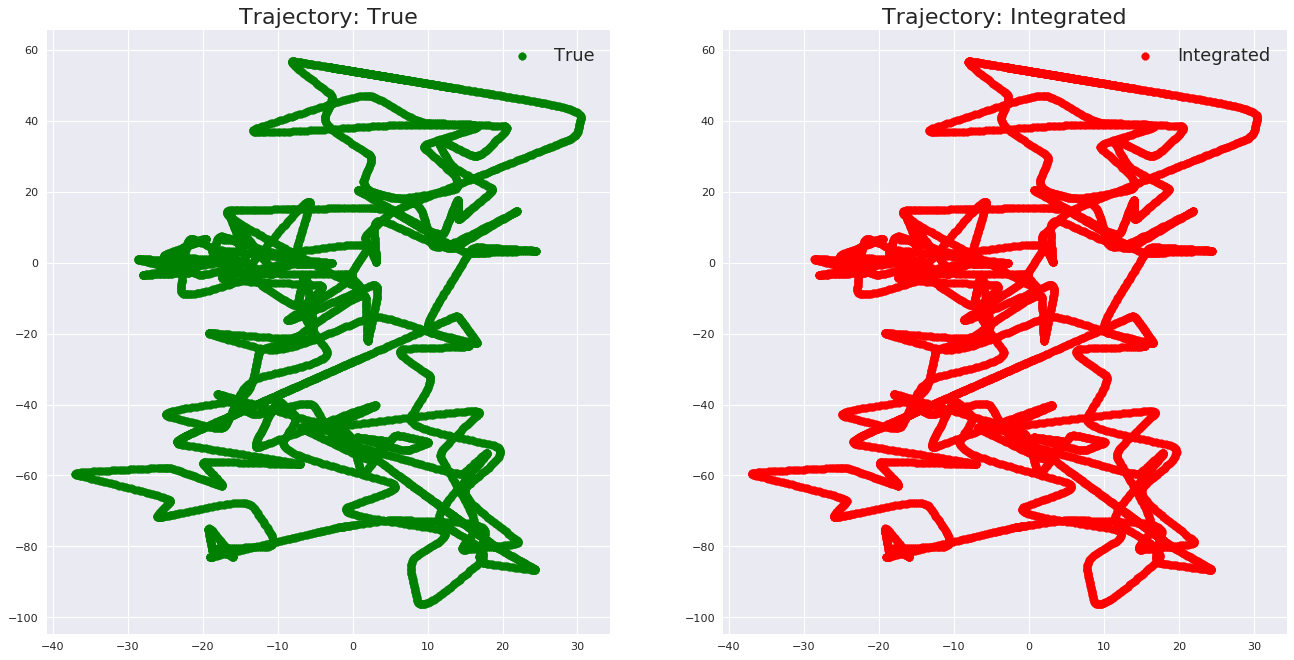

In [56]:
gen2 = integrateTrajectoryAccelerationBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                           initialOrientation=dataset.loc[1, ['psi', 'theta', 'phi']].values,
                                           initialLinearVelocityBody=X.loc[0, ['dXB', 'dYB', 'dZB']].values,
                                           initialAngularVelocity=X.loc[0, ['dPsi', 'dTheta', 'dPhi']].values,
                                           
                                           linearAccelerationsBody=y[['d2XB', 'd2YB', 'd2ZB']].values,
                                           angularAccelerations=y[['d2Psi', 'd2Theta', 'd2Phi']].values,
                                           frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    p, o = next(gen2)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               o.astype(np.float64) - oTrue.astype(np.float64)))

In [57]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

# Acceleration Prediction Models

### MLP Regressor (one step)

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(10)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

2.4245212709383739

In [73]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

### Random Forest (one step)

In [74]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20, random_state=10).fit(xTrain, yTrain)

In [75]:
yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

1.3679540310110418

In [76]:
def predict(frequency, initial, limit):
    actions = X[['moveForward', 'yawCCW', 'yawCW', 'hover']].values
    initialLinearVelocityBody = X.loc[0, ['dXB', 'dYB', 'dZB']].values
    initialAngularVelocity = X.loc[0, ['dPsi', 'dTheta', 'dPhi']].values
    initialOrientation = initial[['psi', 'theta', 'psi']].values
    
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((initialLinearVelocityBody, initialAngularVelocity, 
                                 getGravityVector(*initialOrientation[[0, 1]]), actions[i]))
        else:
            s0 = X.iloc[0].values
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        
        initialAngularVelocity = integrateAngularVelocity(initialAngularVelocity, s1[[3, 4, 5]], frequency)
        nextOrientation = integrateOrientation(initialOrientation, initialAngularVelocity, frequency)
        initialLinearVelocityBody = integrateLinearVelocity(initialLinearVelocityBody, s1[[0, 1, 2]], frequency)
        deltaQuaternion = eulerToQuaternion(*nextOrientation) * eulerToQuaternion(*initialOrientation).inverse.unit
        initialLinearVelocityBody = deltaQuaternion.unit.rotate(initialLinearVelocityBody)
        initialOrientation = nextOrientation

        linear_velocities[i-1] = initialLinearVelocityBody
        angular_velocites[i-1] = initialAngularVelocity
    
    return linear_velocities, angular_velocites

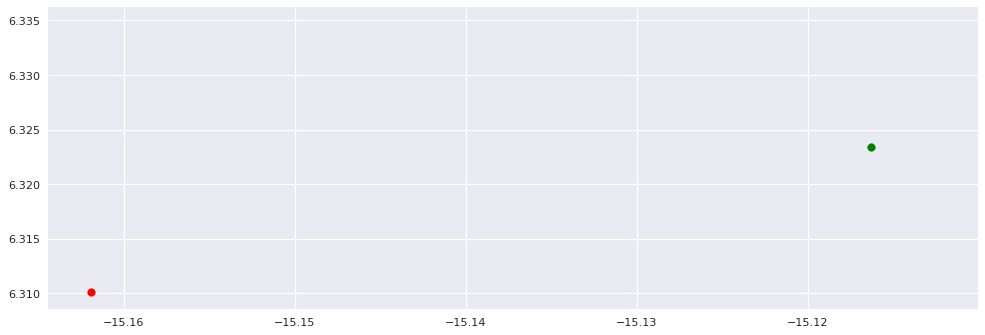

In [81]:
limit = 2
prediction_error = np.zeros((limit, 6))

initial = dataset.iloc[0]
linear_velocities, angular_velocities = predict(10.0, initial, limit)

gen2 = integrateTrajectoryVelocityBody(initialPosition=initial[['x', 'y', 'z']].values,
                                       initialOrientation=initial[['psi', 'theta', 'phi']].values,
                                       linearVelocitiesBody=linear_velocities,
                                       angularVelocities=angular_velocities,
                                       frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['psi', 'theta', 'phi']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))


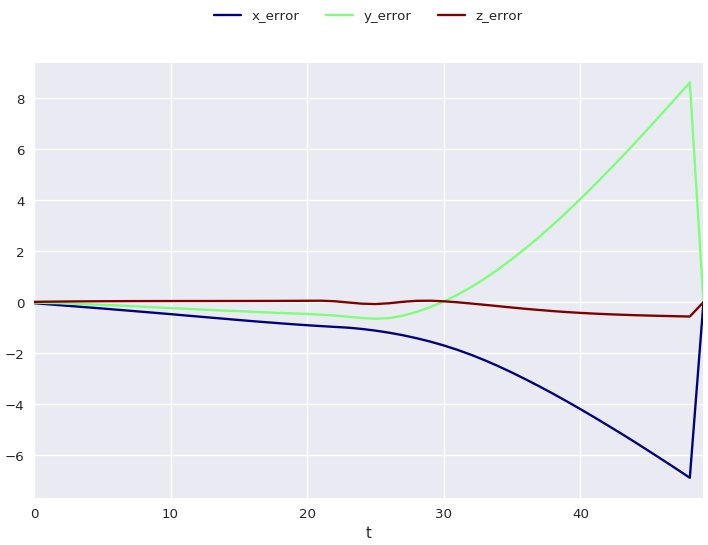

In [71]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['x_error', 'y_error', 'z_error',
                                                              'psi_error', 'theta_error', 'phi_error'])
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


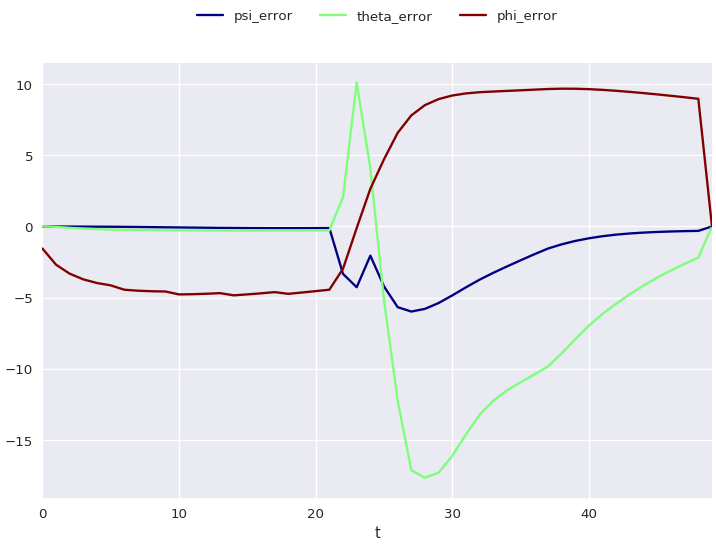

In [72]:
display(prediction_error_df)

### Least-square regression on free parameters (6-d, gravity vector) (one step)

In [13]:
def d2Psi(x, cpsi, c1, d1):
    # Cφ * dPsi + C1 * (moveForward + -hover) + D1
    pass

def d2Theta(x, ctheta, c2, c3, d2):
    # Ċθ * dTheta + C2 * (moveForward + -hover) + D2
    return ctheta * x['dTheta'] + c2 * x['moveForward'] + c3 * x['hover'] + d2

def d2Phi(x, cphi, c4, d3):
    # Cω * dPhi + C3 * (-yawCw + yawCCw) + D3
    return cphi * x['dPhi'] + c4 * (-x['yawCW'] + x['yawCCW']) + d3

def d2XB(x):
    # Cx * dXB + gx
    pass

def d2YB(x):
    # Cy * dYB + gy + D0
    pass

def d2ZB(x):
    # Cz * dZB + gz + C4 * u4 + D4
    pass

In [57]:
from scipy.optimize import curve_fit

d2Theta_fitted = partial(d2Theta, **dict(zip(inspect.getargspec(d2Theta).args[1:], curve_fit(d2Theta, X, y['d2Theta'])[0])))
d2Phi_fitted = partial(d2Phi, **dict(zip(inspect.getargspec(d2Phi).args[1:], curve_fit(d2Phi, X, y['d2Phi'])[0])))

In [58]:
mean_squared_error(d2Theta_fitted(x=X).values, y['d2Theta'].values) ** 0.5

6.473950355407716